In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def get_plate_data(plate_id, data_folder='../data/qPCR-data'):
    ''' Given a plate id:
          1. Locate the annotation csv file and the quantification Cq results csv file
          2. Extract useful data, merge and return the data frame
    '''
    annotation_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*annotation.csv'))
    assert len(annotation_files) == 1
    annotation_file = annotation_files[0]
    
    exported_csv_folders = glob.glob(os.path.join(data_folder, '*'+plate_id+'*'+os.path.sep))
    assert len(exported_csv_folders) == 1
    exported_csv_folder = exported_csv_folders[0]
    
    data_files = glob.glob(os.path.join(exported_csv_folder, '*Quantification Cq Results.csv'))
    assert len(data_files) == 1
    data_file = data_files[0]
    
    df = pd.read_csv(annotation_file)
    df_annotation = df[['Well', 'Sample', 'Primer']]
    
    df = pd.read_csv(data_file)
    df_data = df[['Well', 'Cq']]
    
    df = df_annotation.merge(df_data, on='Well')
    df.dropna(inplace=True)
    
    return df

def get_expression_data(df, test_primer, ref_primer='Rps29 v1'):
    ''' From the data frame containing qPCR data and annotation, 
        calculate average values of replicates and deltaCq values of each sample
        
    '''
    for i in ['Well', 'Sample', 'Primer', 'Cq']:
        assert i in df.columns
    
    df_ref = df[df.Primer==ref_primer]
    df_ref.rename(columns={'Cq': 'Cq_ref'}, inplace=True)
    
    df_test = df[df.Primer==test_primer]
    df_test.rename(columns={'Cq': 'Cq_test'}, inplace=True)
    
    # calculate average values of technical replicates
    df_ref_mean = df_ref.groupby('Sample').mean()
    df_ref_mean.reset_index(inplace=True)
    
    df_test_mean = df_test.groupby('Sample').mean()
    df_test_mean.reset_index(inplace=True)
    
    df = df_ref_mean.merge(df_test_mean, on='Sample')
    df['deltaCq'] = df.Cq_test - df.Cq_ref
    df['relExp'] = 2**(-df.deltaCq)
    df['Group'] = [df.Sample[i][:-2] for i in range(len(df))]
    
    return df


In [3]:
df = get_plate_data('220519-plate3')

In [4]:
df_sg3 = get_expression_data(df, test_primer='Serpinh1 sg3 v1')

In [5]:
df_sg3

,Sample,Cq_ref,Cq_test,deltaCq,relExp,Group
0,A-188-1,19.267236,24.720419,5.453183,0.022826,A-188
1,A-188-2,19.347161,24.778090,5.430929,0.023181,A-188
2,A-188-3,19.163274,24.564533,5.401259,0.023662,A-188
3,A-188-4,19.316662,25.509558,6.192897,0.013669,A-188
4,A-188-5,20.583479,28.142526,7.559047,0.005303,A-188
5,A-230-1,19.368765,26.272487,6.903722,0.008352,A-230
6,A-230-2,19.581540,27.146657,7.565117,0.005280,A-230
7,A-230-3,19.592097,26.250663,6.658566,0.009899,A-230
8,A-230-4,20.074441,27.008938,6.934496,0.008175,A-230
9,A-230-5,19.517504,26.675124,7.157621,0.007004,A-230


<AxesSubplot:xlabel='Group', ylabel='relExp'>

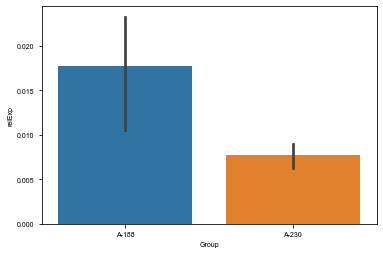

In [14]:
sns.barplot(data=df_sg3, x='Group', y='relExp')
# sns.scatterplot(data=df_sg3, x='Group', y='relExp')

(0.0, 0.03)

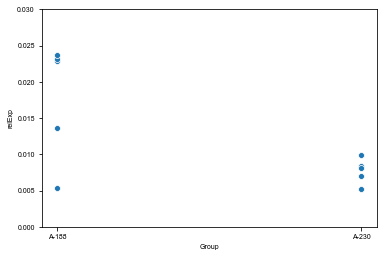

In [17]:
# sns.barplot(data=df_sg3, x='Group', y='relExp')
ax = sns.scatterplot(data=df_sg3, x='Group', y='relExp')
ax.set_ylim([0,0.03])

In [7]:
df_temp = df_sg3
tukeyTest(df_temp.relExp, df_temp.Group)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 A-188  A-230    -0.01 0.0271 -0.0185 -0.0015   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.02707536]
